In [34]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Concat all files into one file

In [35]:
path =r'./' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

### Drop rows that contain NA values 

In [36]:
table=frame.dropna()

In [37]:
TestFromBeg=table

### Mapping from words to numbers (for better analysis)
#### Example: Severity of the accident: 1- easy, 2- Hard, 3- deadly


In [38]:

mapping= {'בוקר': 1, 'צהריים': 2, 'אחר צהריים': 3, 'ערב': 4, 'לילה': 5}
mapping2= {'קלה': 1, 'קשה': 2,'קטלנית': 3}
mapping3= {'התנגשות עם בעל חיים' : 1,'התנגשות עם רכב שנעצר ללא חניה' : 2,'התנגשות אחור אל צד' : 3,'התנגשות אחור אל חזית' : 4,'פגיעה בנוסע בתוך כלי רכב' : 5,'פגיעה ממטען של רכב' : 6,'שריפה' : 7,'פגיעה בנוסע בתוך כלי רכב' : 8,'לא ידוע' : 9,'נפילה ברכב נע' : 10,'התנגשות חזית אל צד' : 11,'התנגשות עם עצם דומם' : 12,'התנגשות צד בצד' : 13,'פגיעה בהולך רגל' : 14,'התנגשות חזית אל חזית' : 15,'התהפכות' : 16,'התנגשות חזית באחור' : 17,'אחר' : 18,'התנגשות עם רכב חונה' : 19,'החלקה' : 20,'ירידה מהכביש או עלייה למדרכה' : 21,}
table = table.replace({'יום\לילה': mapping})
table = table.replace({'חומרת תאונה': mapping2})
table = table.replace({'סוג תאונה': mapping3})

### Because the concat action, we still have columns headers at the middle of the Dataframe
### so we will remove those rows

In [39]:
table = table[table['פצועים קשה'] != 'פצועים קשה']

In [40]:
table['map-distance']= pd.Series(2, index = table.index)

### creating new dataframe that will contain even accidents amount between Easy/Hard/Deadly accidents 

In [41]:
sort_table = table
easy_table =sort_table[sort_table['חומרת תאונה'] == 1]
hard_deadly_table =sort_table[sort_table['חומרת תאונה'] != 1]
easy_less_table=easy_table[:500]
hard_table= hard_deadly_table[hard_deadly_table['חומרת תאונה'] == 2]
hard_less_table=hard_table[:500]
deadly_table= hard_deadly_table[hard_deadly_table['חומרת תאונה'] == 3]

In [42]:
frame = pd.DataFrame()
list_ = []
list_.append(easy_less_table)
list_.append(hard_less_table)
list_.append(deadly_table)
frame = pd.concat(list_)
even_table = frame.sample(frac=1).reset_index(drop=True)


### Split the data to train and test.
### 70% Train, 30% Test

In [43]:
from sklearn.cross_validation import train_test_split
Train,Test = train_test_split(even_table, test_size = 0.3,
                              random_state = 176)

### Choosing 

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
Train_y= Train.values[:,4]
#Train_x= Train.values[:,[1,2,3,5,6,7,8,9,10,11,12,13,14]]
#Test_x= Test.values[:,[1,2,3,5,6,7,8,9,10,11,12,13,14]]
Train_x= Train.values[:,[1,2,3,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
Test_x= Test.values[:,[1,2,3,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
Test_y= Test.values[:,4]

In [45]:
regr = linear_model.LinearRegression()
regr.fit(Train_x,Train_y)
predictions=regr.predict(Test_x)

# מהי חומרת התאונה

In [46]:
mean_squared_error(Test_y,predictions)**0.5

0.6152928445263508

In [47]:
r2_score(Test_y,predictions)


0.4126501086026655

In [49]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# Building Decision Tree - CART Algorithm (gini criteria)
dt_train_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=5, min_samples_leaf=5)
# Train
Train_y=Train_y.astype('int')
model2=dt_train_gini.fit(Train_x, Train_y)

train accuracy:
0.9410058027079303

test accuracy:
0.9256756756756757

test classification report:
             precision    recall  f1-score   support

          1       0.80      1.00      0.89       134
          2       1.00      0.79      0.88       157
          3       1.00      1.00      1.00       153

avg / total       0.94      0.93      0.93       444

recall - the number of correct positive results divided by the actual positive results
precision - the number of correct positive results divided by the number of predicted positive results


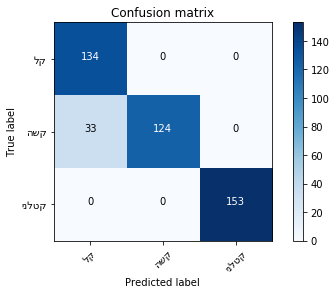

In [50]:
from sklearn.metrics import classification_report, confusion_matrix  
import itertools

Test_y= Test_y.astype('int')
accuracy = model2.score(Train_x, Train_y)
print("train accuracy:")
print(accuracy)
print()
print("test accuracy:")
accuracy = model2.score(Test_x, Test_y)
print(accuracy)

print()
y_pred = model2.predict(Test_x)  
#print("test confusion matrix:")
cnf=confusion_matrix(Test_y,y_pred )
my_columns = ["לק", "השק", "ינלטק"]
class_names=my_columns
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cnf, classes=class_names,
                     title='Confusion matrix')
print("test classification report:")
print(classification_report(Test_y, y_pred))  
print("recall - the number of correct positive results divided by the actual positive results") 
print("precision - the number of correct positive results divided by the number of predicted positive results") 



In [51]:
exp = table

In [53]:
df1 = exp.drop(["סוג דרך", "איכות העיגון", "צומת קרוב","תאריך"], axis = 1)

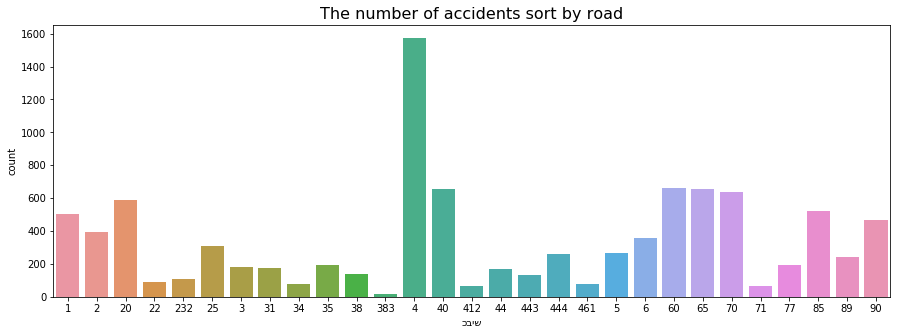

In [54]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.title("The number of accidents sort by road",fontsize=16)
sns.countplot(exp['כביש'],label="Count")
plt.show()

In [55]:
#Roads = TestFromBeg[['כביש']]

In [56]:
#RoadsNum= Roads.groupby(['כביש']).sum()

In [57]:
#dates = TestFromBeg[['תאריך']]

In [58]:
#datesUnique = dates.groupby(['תאריך']).sum()

In [59]:
###################

In [60]:
Time = table.loc[:,['יום\לילה','תאריך','הרוגים']]

In [61]:
Time['תאריך'] = pd.to_datetime(Time['תאריך'])

In [62]:
Time['year']=Time['תאריך'].dt.year

Text(0,0.5,'Accidents')

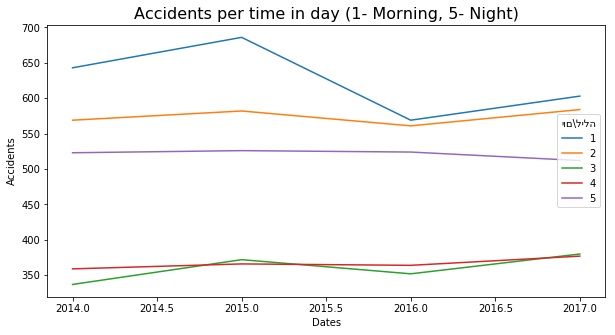

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
Time.groupby(['year','יום\לילה']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Accidents per time in day (1- Morning, 5- Night)",fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Accidents')

In [64]:
many = table.loc[:,['כביש','תאריך','הרוגים']]

In [65]:
many['תאריך'] = pd.to_datetime(many['תאריך'])

In [66]:
many['year']=many['תאריך'].dt.year

Text(0,0.5,'Accidents')

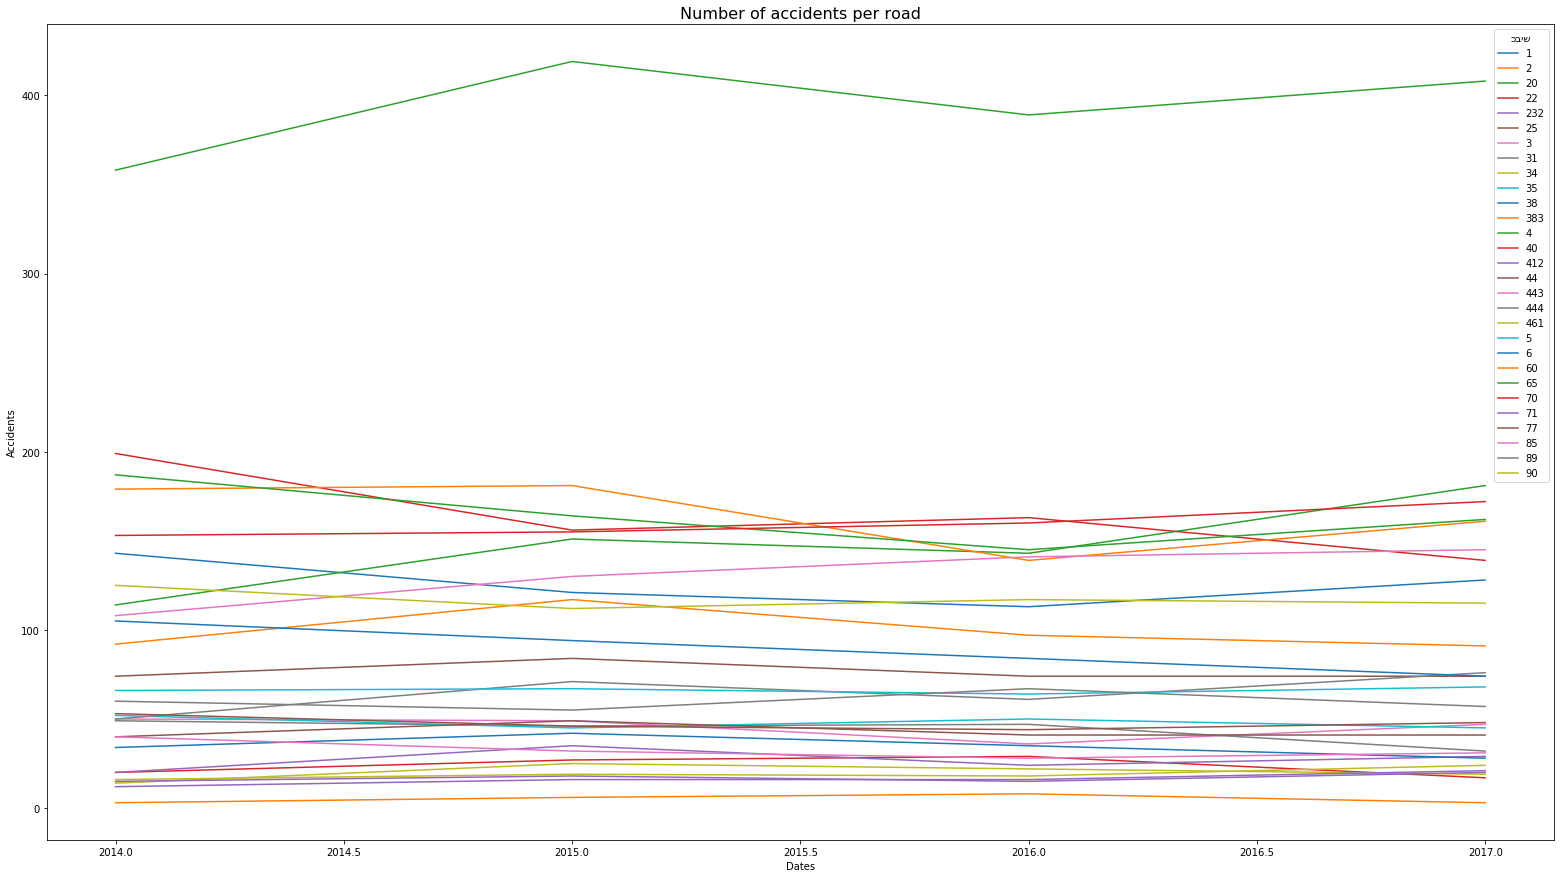

In [67]:
fig, ax = plt.subplots(figsize=(27,15))
many.groupby(['year','כביש']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per road",fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Accidents')

In [68]:
#many.groupby(['year','כביש']).count()['הרוגים']

### Create a dataframe per road

In [69]:
df_road= pd.read_csv('roads_4_71.csv')
df_road2= pd.read_csv('roads_65_70.csv')
df_road3= pd.read_csv('roads_85_77.csv')
df_road4= pd.read_csv('roads_6_20.csv')
df_road5= pd.read_csv('roads_4_71.csv')

table_road_raw=df_road.dropna()
table_road_raw = table_road_raw[table_road_raw['פצועים קשה'] != 'פצועים קשה']
table_road =table_road_raw[table_road_raw['כביש'] == '4']

table_road_raw2=df_road2.dropna()
table_road_raw2 = table_road_raw2[table_road_raw2['פצועים קשה'] != 'פצועים קשה']
table_road2 =table_road_raw2[table_road_raw2['כביש'] == '65']

table_road_raw3=df_road3.dropna()
table_road_raw3 = table_road_raw3[table_road_raw3['פצועים קשה'] != 'פצועים קשה']
table_road3 =table_road_raw3[table_road_raw3['כביש'] == '85']

table_road_raw4=df_road4.dropna()
table_road_raw4 = table_road_raw4[table_road_raw4['פצועים קשה'] != 'פצועים קשה']
table_road4 =table_road_raw4[table_road_raw4['כביש'] == '20']

table_road_raw5=df_road5.dropna()
table_road_raw5 = table_road_raw5[table_road_raw5['פצועים קשה'] != 'פצועים קשה']
table_road5 =table_road_raw5[table_road_raw5['כביש'] == '4']

### Define which columns will be in the data frame
### Convert the kilometers to an int type
### adding Year columns and Month column.

In [70]:
table_location = table_road.loc[:,['הרוגים','תאריך','ק"מ']]
table_location.loc[:,'תאריך'] = pd.to_datetime(table_location.loc[:,'תאריך'])
table_location.loc[:,'year']=table_location.loc[:,'תאריך'].dt.year
table_location.loc[:,'ק"מ'] = pd.to_numeric(table_location.loc[:,'ק"מ'])
table_location.loc[:,'ק"מ'] = table_location.loc[:,'ק"מ'].astype(int)

table_location2 = table_road2.loc[:,['הרוגים','תאריך','ק"מ']]
table_location2.loc[:,'תאריך'] = pd.to_datetime(table_location2.loc[:,'תאריך'])
table_location2.loc[:,'year']=table_location2.loc[:,'תאריך'].dt.year
table_location2.loc[:,'ק"מ'] = pd.to_numeric(table_location2.loc[:,'ק"מ'])
table_location2.loc[:,'ק"מ'] = table_location2.loc[:,'ק"מ'].astype(int)

table_location3 = table_road3.loc[:,['הרוגים','תאריך','ק"מ']]
table_location3.loc[:,'תאריך'] = pd.to_datetime(table_location3.loc[:,'תאריך'])
table_location3.loc[:,'year']=table_location3.loc[:,'תאריך'].dt.year
table_location3.loc[:,'ק"מ'] = pd.to_numeric(table_location3.loc[:,'ק"מ'])
table_location3.loc[:,'ק"מ'] = table_location3.loc[:,'ק"מ'].astype(int)

table_location4 = table_road4.loc[:,['הרוגים','תאריך','ק"מ']]
table_location4.loc[:,'תאריך'] = pd.to_datetime(table_location4.loc[:,'תאריך'])
table_location4.loc[:,'year']=table_location4.loc[:,'תאריך'].dt.year
table_location4.loc[:,'ק"מ'] = pd.to_numeric(table_location4.loc[:,'ק"מ'])
table_location4.loc[:,'ק"מ'] = table_location4.loc[:,'ק"מ'].astype(int)

table_location5 = table_road5.loc[:,['הרוגים','תאריך','ק"מ']]
table_location5.loc[:,'תאריך'] = pd.to_datetime(table_location5.loc[:,'תאריך'])
table_location5.loc[:,'year']=table_location5.loc[:,'תאריך'].dt.year
table_location5_ =table_location5[table_location5['year'] == 2017]
table_location5_.loc[:,'month']=table_location5_.loc[:,'תאריך'].dt.month
table_location5_.loc[:,'ק"מ'] = pd.to_numeric(table_location5_.loc[:,'ק"מ'])
table_location5_.loc[:,'ק"מ'] = table_location5_.loc[:,'ק"מ'].astype(int)

table_location6_ =table_location5[table_location5['year'] != 2017]
table_location6_.loc[:,'month']=table_location6_.loc[:,'תאריך'].dt.month
table_location6_.loc[:,'ק"מ'] = pd.to_numeric(table_location6_.loc[:,'ק"מ'])
table_location6_.loc[:,'ק"מ'] = table_location6_.loc[:,'ק"מ'].astype(int)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0,0.5,'Accidents')

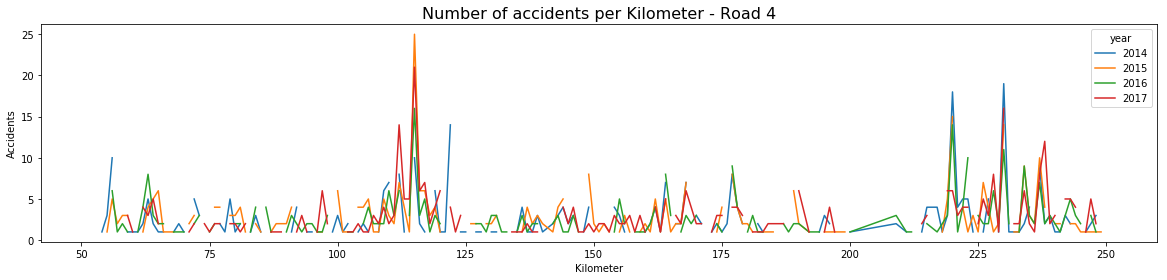

In [71]:
fig, ax = plt.subplots(figsize=(20,4))
table_location.groupby(['ק"מ','year']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per Kilometer - Road 4",fontsize=16)
plt.xlabel('Kilometer')
plt.ylabel('Accidents')

Text(0,0.5,'Accidents')

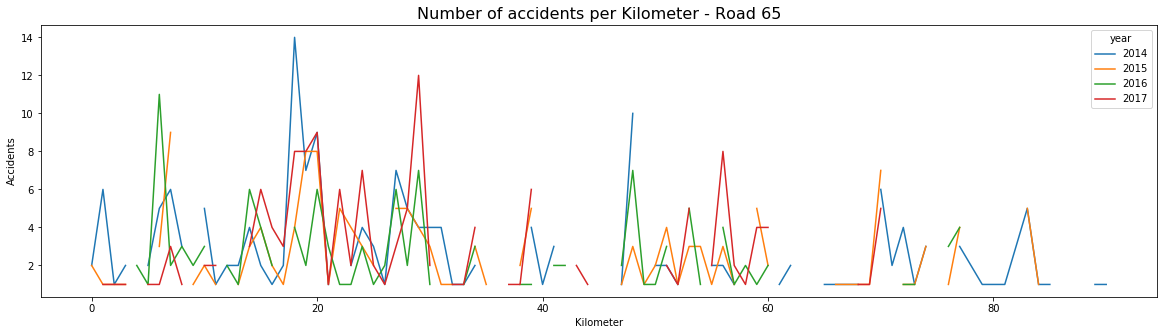

In [72]:
fig, ax = plt.subplots(figsize=(20,5))
table_location2.groupby(['ק"מ','year']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per Kilometer - Road 65",fontsize=16)
plt.xlabel('Kilometer')
plt.ylabel('Accidents')

Text(0,0.5,'Accidents')

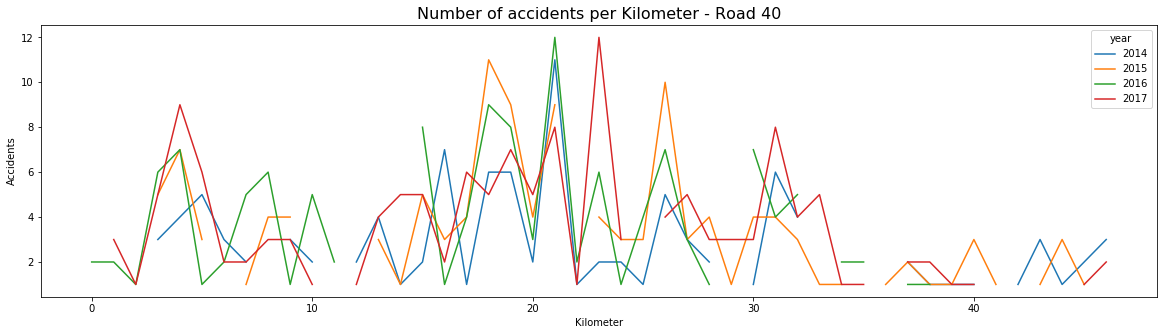

In [73]:
fig, ax = plt.subplots(figsize=(20,5))
table_location3.groupby(['ק"מ','year']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per Kilometer - Road 40",fontsize=16)
plt.xlabel('Kilometer')
plt.ylabel('Accidents')

Text(0,0.5,'Accidents')

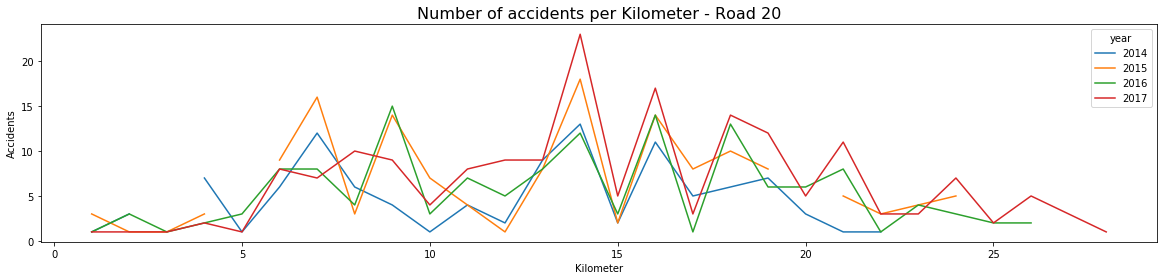

In [74]:
fig, ax = plt.subplots(figsize=(20,4))
table_location4.groupby(['ק"מ','year']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per Kilometer - Road 20",fontsize=16)
plt.xlabel('Kilometer')
plt.ylabel('Accidents')


Text(0,0.5,'Accidents')

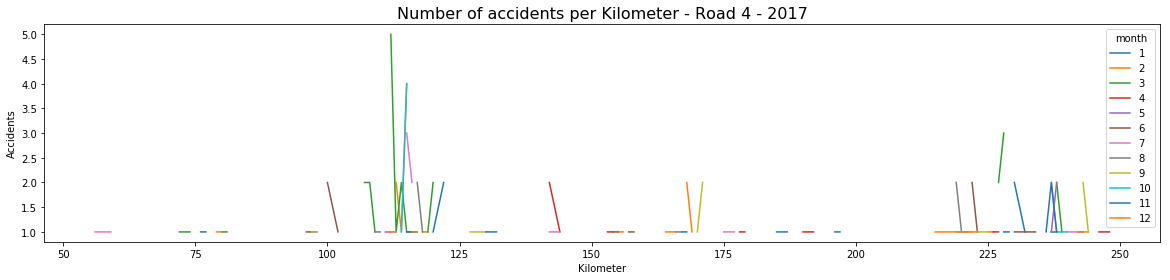

In [75]:
fig, ax = plt.subplots(figsize=(20,4))
table_location5_.groupby(['ק"מ','month']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per Kilometer - Road 4 - 2017",fontsize=16)
plt.xlabel('Kilometer')
plt.ylabel('Accidents')

Text(0,0.5,'Accidents')

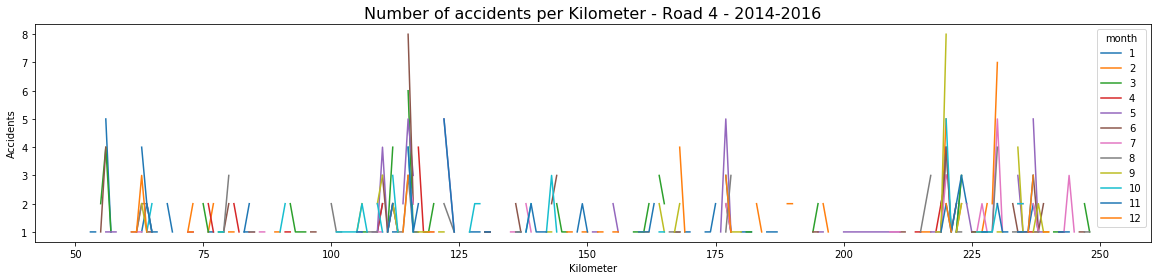

In [76]:
fig, ax = plt.subplots(figsize=(20,4))
table_location6_.groupby(['ק"מ','month']).count()['הרוגים'].unstack().plot(ax=ax)
plt.title("Number of accidents per Kilometer - Road 4 - 2014-2016",fontsize=16)
plt.xlabel('Kilometer')
plt.ylabel('Accidents')